## Configuration

In [2]:
dataset = "https://ldt116.github.io/ml-labs/datasets/spam/spam.csv"

## Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  

## Loading the Dataset

In [19]:
import pandas as pd

data = pd.read_csv(dataset, encoding='latin-1')

## Data Analytics

In [20]:
# list all ham messages
ham_messages=data[data['v1']=='ham']["v2"]
ham_words = " ".join(ham_messages).split()

In [23]:
from collections import Counter

count1 = Counter(ham_words).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})

In [24]:
count2 = Counter(" ".join(data[data['v1']=='spam']["v2"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

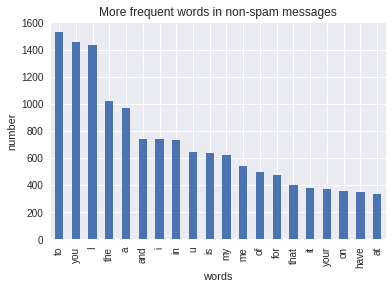

In [29]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

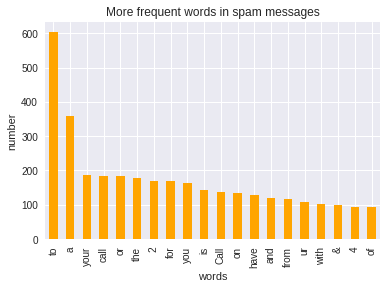

In [30]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

We can see that the majority of frequent words in both classes are stop words such as 'to', 'a', 'or' and so on. <p>
With stop words we refer to the most common words in a language, there is no simgle, universal list of stop words. <p>

## Feature Engineering

Text preprocessing, tokenizing and filtering of stopwords are included in a high level component that is able to build a dictionary of features and transform documents to feature vectors.<p>
**We remove the stop words in order to improve the analytics**

In [27]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["v2"])
np.shape(X)

(5572, 8404)

We have created more than 8400 new features. The new feature $j$ in the row $i$ is equal to 1 if the word $w_{j}$ appears in the text example $i$. It is zero if not.

## Predictive Analysis

**My goal is to predict if a new sms is spam or non-spam. I assume that is much worse misclassify non-spam than misclassify an spam. (I don't want to have false positives)**
<p>
The reason is because I normally don't check the spam messages.<p> The two possible situations are:<p>
1. New spam sms in my inbox. (False negative).<p>
OUTCOME: I delete it.<p>
2. New non-spam sms in my spam folder (False positive).<p>  OUTCOME: I probably don't read it. <p>
I prefer the first option!!!

First we transform the variable spam/non-spam into binary variable, then we split our data set in training set and test set. 

In [32]:
data["v1"]=data["v1"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['v1'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(3733, 8404), (1839, 8404)]


### Multinomial naive bayes classifier

We train different bayes models changing the regularization parameter $\alpha$. <p>
We evaluate the accuracy, recall and precision of the model with the test set.

In [36]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

Let's see the first 10 learning models and their metrics!

In [34]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998661,0.974443,0.920635,0.895753
1,0.11001,0.997857,0.976074,0.936508,0.893939
2,0.22001,0.997857,0.977162,0.936508,0.900763
3,0.33001,0.997589,0.977162,0.936508,0.900763
4,0.44001,0.997053,0.977162,0.936508,0.900763
5,0.55001,0.996250,0.976618,0.936508,0.897338
6,0.66001,0.996518,0.976074,0.932540,0.896947
7,0.77001,0.996518,0.976074,0.924603,0.903101
8,0.88001,0.996250,0.976074,0.924603,0.903101
9,0.99001,0.995982,0.976074,0.920635,0.906250


I select the model with the most test precision

In [35]:
best_index = models['Test Precision'].idxmax() #note: lay ra id cua gia tri max
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

**My best model does not produce any false positive, which is our goal.** <p>
Let's see if there is more than one model with 100% precision !

In [36]:
models[models['Test Precision']==1].head(n=5)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
143,15.73001,0.979641,0.969549,0.777778,1.0
144,15.84001,0.979641,0.969549,0.777778,1.0
145,15.95001,0.979641,0.969549,0.777778,1.0
146,16.06001,0.979373,0.969549,0.777778,1.0
147,16.17001,0.979373,0.969549,0.777778,1.0


Between these models with the highest possible precision, we are going to select which has more test accuracy.

In [37]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

#### Confusion matrix with naive bayes classifier

In [38]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,56,196


## Conclusion

- We misclassify 56 spam messages as non-spam emails whereas we don't misclassify any non-spam message.

- [improve_spam_filter_system](http://www.iraj.in/journal/journal_file/journal_pdf/12-351-149622523082-87.pdf)
- [improve_spam_filter_system_1](https://hackernoon.com/how-to-build-a-simple-spam-detecting-machine-learning-classifier-4471fe6b816e)
- [spm_filter_method](http://airccse.org/journal/jcsit/0211ijcsit12.pdf)